In [ ]:
#importing the necessary packets
import numpy as np
import re
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import io
import pandas as pd
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

#Uploading the data file
data = files.upload()



Saving SMPS_MPSS_20240521.in3 to SMPS_MPSS_20240521.in3


0      00:00
1      00:05
2      00:10
3      00:15
4      00:20
       ...  
145    12:05
146    12:10
147    12:15
148    12:20
149    12:25
Name: 0, Length: 150, dtype: object
120
Number of diameters: 71
 VOLUME PLOT DATA:5.863058933112446, 0.6298979280762949,24420.26236672483
Mode: 236.58, Sigma: 299.38, FWHM: 383.99
Mu counts = 4.478198226226578
Amp counts = 11916880.423738046
Counts sigma = 395.9905203137858
 COUNTS PLOT DATA: 4.478198226226578,1.270501321458575,11916880.423738046
Mode (Counts): 17.53, Sigma (Counts): 395.99, FWHM (Counts): 74.32
1.270501321458575


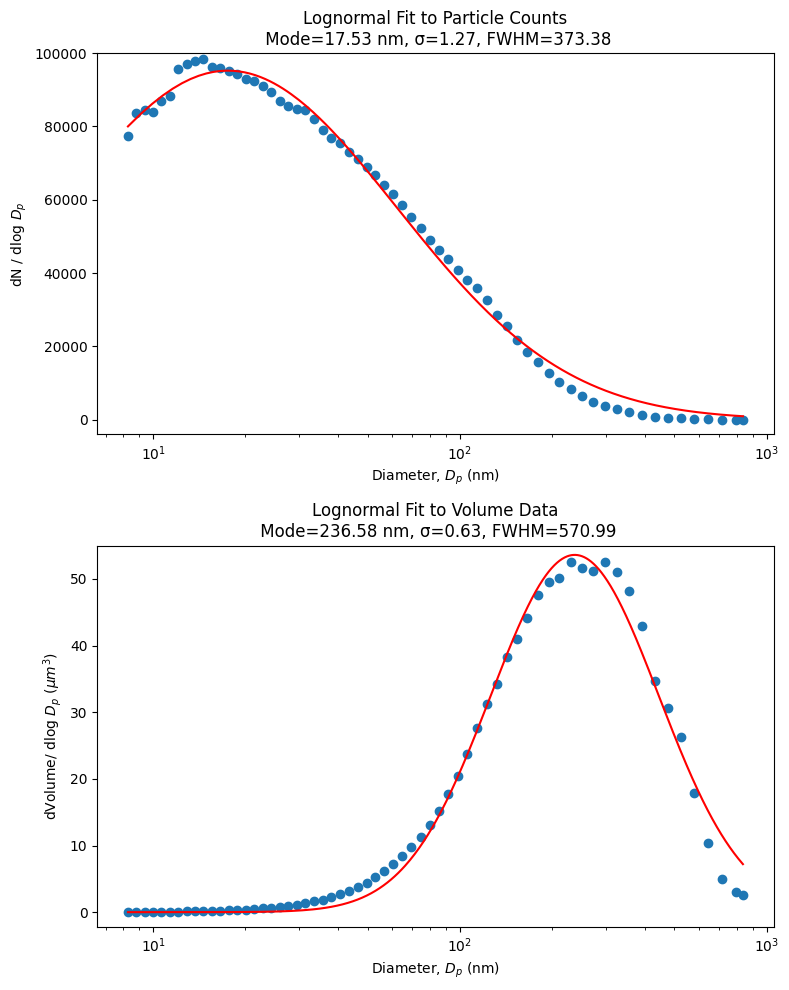

In [ ]:
timestamp_to_search = '10:00'       #Code for unimodal without data exclusion

# Function to remove all letters from a string
def remove_letters(s):
    return re.sub(r'[A-Za-z]', '', str(s))

# Read the tab-separated data file into a pandas DataFrame
df = pd.read_csv('SMPS_MPSS_20240521.in3', delimiter="\t", header=None)

# Apply the function to remove all letters from each element in the DataFrame
df_cleaned = df.applymap(remove_letters)

# Remove every second row (1-indexed: removing rows 2, 4, 6, etc.)
# Remove the 2, 3, and 4th columns
# Make all the data numeric
df_cleaned = df_cleaned.iloc[1::2]
df_cleaned = df_cleaned.drop(columns=[1, 2, 3])
df_cleaned = df_cleaned.apply(pd.to_numeric, errors='coerce')

# Subtract 141 from every data point in the first column to make it a fraction of time
#141 is changed based on the day of measurement
df_cleaned.iloc[:, 0] = df_cleaned.iloc[:, 0] - 141

# Convert the time to minutes
total_minutes = df_cleaned.iloc[:, 0] * 24 * 60

# Round to the nearest multiple of 5 minutes
rounded_minutes = ((total_minutes + 2.5) // 5 * 5).astype(int)

# Convert rounded minutes back to hours and minutes
hours = (rounded_minutes // 60).astype(int)
minutes = (rounded_minutes % 60).astype(int)

# Format hours and minutes into HH:MM format
df_cleaned.iloc[:, 0] = hours.astype(str).str.zfill(2) + ':' + minutes.astype(str).str.zfill(2)

df_cleaned.reset_index(drop=True, inplace=True)


# Display the first column
first_column = df_cleaned.iloc[:, 0]
print(first_column)

# Function to search for a specific timestamp in the DataFrame
def search_timestamp(df, timestamp):
    # Check if the timestamp exists in the first column
    if timestamp in df.iloc[:, 0].values:
        # Get the row index where the timestamp is found
        row_index = df.index[df.iloc[:, 0] == timestamp][0]
        return row_index
    else:
        return None

result = search_timestamp(df_cleaned, timestamp_to_search)


# Function for volume based on diameter
def volume_sphere(diameter):
    radius = diameter / 2  # Convert diameter to radius
    volume = (4/3) * np.pi * (radius**3)  # Volume of a sphere
    return volume

# Diameter data points
diameter = np.array([5.515, 5.690, 6.057, 6.447, 6.864, 7.307, 7.779, 8.283, 8.819, 9.390,
                     9.998, 10.647, 11.338, 12.075, 12.861, 13.698, 14.591, 15.544, 16.560,
                     17.644, 18.800, 20.035, 21.353, 22.760, 24.263, 25.869, 27.586, 29.420,
                     31.383, 33.482, 35.729, 38.135, 40.712, 43.475, 46.438, 49.617, 53.032,
                     56.701, 60.647, 64.895, 69.470, 74.405, 79.733, 85.490, 91.721, 98.472,
                     105.798, 113.760, 122.426, 131.875, 142.197, 153.494, 165.882, 179.497,
                     194.490, 211.038, 229.342, 249.634, 272.176, 297.271, 325.262, 356.541,
                     391.548, 430.785, 474.816, 524.279, 579.890, 642.461, 712.906, 792.262,
                     835.665])


# Filter diameters greater than 8 nm
mask = diameter > 8
filtered_diameter = diameter[mask]

# Averaging the data for each location. Depending on locations changing amount of datasets used
raw_counts = [(i+j+k)/3 for i,j,k in zip(df_cleaned.iloc[result, 1:], df_cleaned.iloc[result+1, 1:], df_cleaned.iloc[result+3, 1:])]
#raw_counts = [(i+j)/2 for i,j in zip( df_cleaned.iloc[result, 1:], df_cleaned.iloc[result+1, 1:])]
#raw_counts = [(i) for i in df_cleaned.iloc[result+2, 1:]]
filtered_counts = [count for count, d in zip(raw_counts, diameter) if d > 8]

# Calculate number distribution
counts = [count/np.log(d) for count, d in zip(filtered_counts, filtered_diameter)]

# Calculate volume distribution
normalized_volume = [(counts * volume_sphere(d))*(10**(-9)) for counts, d in zip(counts, filtered_diameter)]


# Lognormal function for fit
def lognormal(x, mu, sigma, amp):
    return amp * np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2)) / (x * sigma * np.sqrt(2 * np.pi))

#Function used to calculate FWHM
def calculate_lognormal_fwhm(mu, sigma):
    # Calculate the maximum value of the lognormal distribution
    max_value = lognormal(np.exp(mu), mu, sigma, 1)

    # Find the points where the value is half of the maximum value
    half_max_value = max_value / 2
    lower_bound = np.exp(mu - sigma * np.sqrt(2 * np.log(2)))
    upper_bound = np.exp(mu + sigma * np.sqrt(2 * np.log(2)))

    # Calculate the FWHM
    fwhm = upper_bound - lower_bound
    return fwhm





# Initial guesses for the fit
mu_guess = np.mean(log_diameter_peak)
sigma_guess = np.std(log_diameter_peak)
amp_guess = np.max(volume_peak)

mu_guess = np.log(200)
sigma_guess = 1
amp_guess = np.max(volume_peak)

# Initial guesses for the parameters (mu, sigma, amp)
initial_guesses = [mu_guess, sigma_guess, amp_guess]

# Perform the curve fit
popt, _ = curve_fit(lognormal, filtered_diameter, normalized_volume, p0=initial_guesses)

# Extract the parameters
mu_log, sigma_log, amp = popt

# Calculate mode
mode = np.exp(mu_log - sigma_log**2)

# Create a fine grid of x and y values for plotting the fit
x_fine = np.linspace(min(filtered_diameter), max(filtered_diameter), 1000)
y_fine = lognormal(x_fine, mu_log, sigma_log, amp)

fwhm = np.exp((mu_log - sigma_log**2) + np.sqrt(2 * sigma_log**2 * np.log(2))) - np.exp((mu_log - sigma_log**2) - np.sqrt(2 * sigma_log**2 * np.log(2)))

# Print the parameters
print(f"Mode: {mode:.2f}, Sigma: {sigma_original:.2f}, FWHM: {fwhm:.2f}")

###########################################################################################

#Initial guesses for Number distributions

mu_guess1 = np.log(350)
sigma_guess1 =0.1
amp_guess1 = 300000

initial_guesses_counts = [mu_guess1, sigma_guess1, amp_guess1]



# Perform the curve fit for counts with adjusted initial guesses
popt_counts, _ = curve_fit(lognormal, filtered_diameter, counts, p0=initial_guesses_counts)

# Extract the parameters for counts
mu_log_counts, sigma_log_counts, amp_counts = popt_counts



# Calculate mode for numbers distributions
mode_counts = np.exp(mu_log_counts - sigma_log_counts**2)


# Create a fine grid of x values for plotting the fit for counts
x_fine_counts = np.linspace(min(filtered_diameter), max(filtered_diameter), 1000)
y_fine_counts = lognormal(x_fine_counts, mu_log_counts, sigma_log_counts, amp_counts)

# Calculate FWHM for counts
fwhm_counts = np.exp((mu_log_counts - sigma_log_counts**2) + np.sqrt(2 * sigma_log_counts**2 * np.log(2))) - np.exp((mu_log_counts - sigma_log_counts**2) - np.sqrt(2 * sigma_log_counts**2 * np.log(2)))
fwhm_counts = calculate_lognormal_fwhm(popt_counts[0], popt_counts[1])
fwhm = calculate_lognormal_fwhm(popt[0], popt[1])

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(8, 10))

#fig.suptitle('Location: Right Edge', fontsize=20)

# Plot Counts
axs[0].scatter(filtered_diameter, counts)
axs[0].set_title(f"Lognormal Fit to Particle Counts\n Mode={mode_counts:.2f} nm, σ={sigma_log_counts:.2f}, FWHM={fwhm_counts:.2f}")
axs[0].set_xlabel('Diameter, $D_{p}$ (nm)')
axs[0].set_ylabel('dN / dlog $D_{p}$ ')
axs[0].set_yscale('linear')
axs[0].set_xscale('log')
axs[0].plot(x_fine_counts, y_fine_counts, label='Lognormal Fit', color='red')
axs[0].set_ylim(-4000,100000)

# Plot Volume
axs[1].set_title((f'Lognormal Fit to Volume Data\n Mode={mode:.2f} nm, σ={sigma_log:.2f}, FWHM={fwhm:.2f}'))
axs[1].scatter(filtered_diameter, normalized_volume)
axs[1].set_xlabel('Diameter, $D_{p}$ (nm)')
axs[1].set_ylabel('dVolume/ dlog $D_{p}$ ($μm^3$)')
axs[1].plot(x_fine, y_fine, label='Lognormal Fit', color='red')
axs[1].set_xscale('log')
axs[1].set_ylim(-2.2,55)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


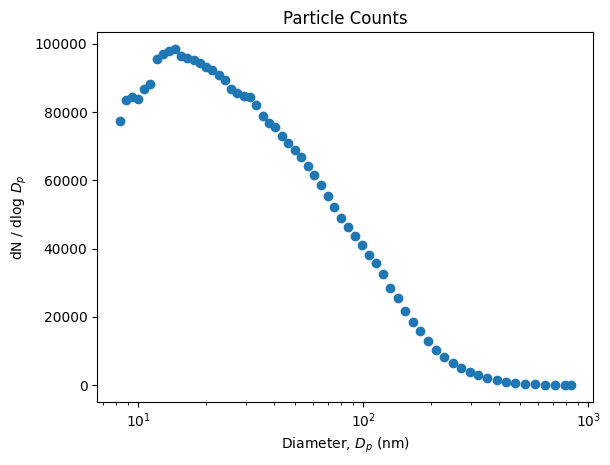

<Figure size 800x1000 with 0 Axes>

In [ ]:
#To plot just the particle counts
plt.scatter(filtered_diameter, counts)
plt.title(f"Particle Counts")
plt.xlabel('Diameter, $D_{p}$ (nm)')
plt.ylabel('dN / dlog $D_{p}$ ')
plt.yscale('linear')
plt.xscale('log')
plt.figure(figsize=(8,10))
plt.show()


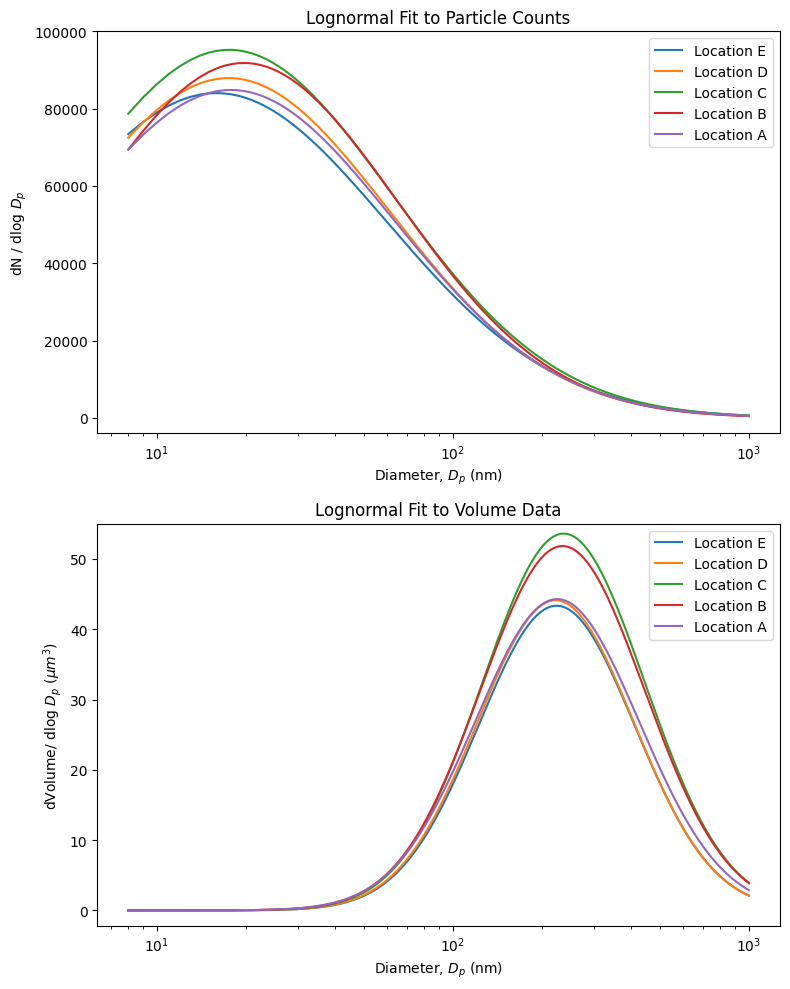

In [ ]:
#Plotting for the dilutions. I manually got the parameters from the code above.

def lognormal(x, mu, sigma, amp):
    return amp * np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2)) / (x * sigma * np.sqrt(2 * np.pi))


# Range of x values
x = np.linspace(8, 1000, 1000)



fig, axs = plt.subplots(2, 1, figsize=(8, 10))


# Plot Counts of all the fits
axs[0].set_title(f"Lognormal Fit to Particle Counts")
axs[0].set_xlabel('Diameter, $D_{p}$ (nm)')
axs[0].set_ylabel('dN / dlog $D_{p}$ ')
axs[0].set_yscale('linear')
axs[0].set_xscale('log')
axs[0].plot(x, lognormal(x, 4.506142924130511,1.3194707446032254,10540146.656995721), label='Location E')
axs[0].plot(x, lognormal(x, 4.437928986278292, 1.256343730621755, 10637734.54077162), label='Location D')
axs[0].plot(x, lognormal(x, 4.478198226226578,1.270501321458575,11916880.423738046), label='Location C')
axs[0].plot(x, lognormal(x, 4.423474257313334,1.2019568813344856,11201557.983854456), label='Location B')
axs[0].plot(x, lognormal(x, 4.4689775888475145,1.2611050937043993,10565506.962266792), label='Location A')
axs[0].set_ylim(-4000,100000)
axs[0].legend()
# Plot Volume of all the fits
axs[1].set_title((f'Lognormal Fit to Volume Data'))
axs[1].set_xlabel('Diameter, $D_{p}$ (nm)')
axs[1].set_ylabel('dVolume/ dlog $D_{p}$ ($μm^3$)')
axs[1].plot(x, lognormal(x, 5.780893179805254, 0.6077176367517937,17788.907226107283), label='Location E')
axs[1].plot(x, lognormal(x, 5.773590426316165, 0.6083322443233108,17986.097117092864), label='Location D')
axs[1].plot(x, lognormal(x, 5.863058933112446, 0.6298979280762949,24420.26236672483), label='Location C')
axs[1].plot(x, lognormal(x, 5.86248449445286,0.6364323537824672,23745.904458436784), label='Location B')
axs[1].plot(x, lognormal(x, 5.822681571421966,0.6378017796491599,19522.89869111108), label='Location A')
axs[1].set_xscale('log')
axs[1].set_ylim(-2.2,55)
axs[1].legend()
# Adjust layout
plt.tight_layout()




0      00:00
1      00:05
2      00:10
3      00:15
4      00:20
       ...  
145    12:05
146    12:10
147    12:15
148    12:20
149    12:25
Name: 0, Length: 150, dtype: object
129
Mu volume=5.822681571421966
 VOLUME PLOT DATA: 5.822681571421966,0.6378017796491599,19522.89869111108
Mode: 224.95, Sigma: 293.39, FWHM: 370.52
Mu counts = 4.4689775888475145
 COUNTS PLOT DATA: 4.4689775888475145,1.2611050937043993,10565506.962266792
Mode (Counts): 17.79, Sigma (Counts): 381.99, FWHM (Counts): 74.50
1.2611050937043993


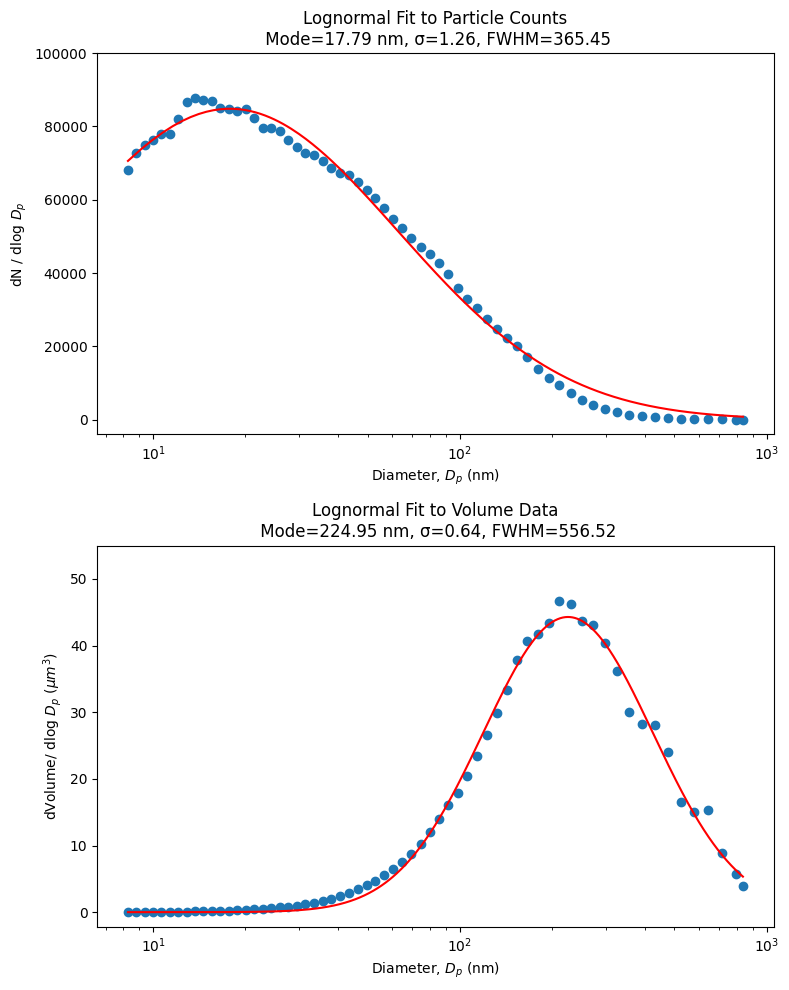

In [ ]:
import numpy as np                      #Unimodal code with exclusion of data
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import re


timestamp_to_search = '10:45'

# Function to remove all letters from a string
def remove_letters(s):
    return re.sub(r'[A-Za-z]', '', str(s))
# Read the tab-separated data file into a pandas DataFrame
df = pd.read_csv('SMPS_MPSS_20240521.in3', delimiter="\t", header=None)

# Apply the function to remove all letters from each element in the DataFrame
df_cleaned = df.applymap(remove_letters)

# Remove every second row (1-indexed: removing rows 2, 4, 6, etc.)
# Remove the 2, 3, and 4th columns
# Make all the data numeric
df_cleaned = df_cleaned.iloc[1::2]
df_cleaned = df_cleaned.drop(columns=[1, 2, 3])
df_cleaned = df_cleaned.apply(pd.to_numeric, errors='coerce')

# Subtract 141 from every data point in the first column to make it a fraction of time
df_cleaned.iloc[:, 0] = df_cleaned.iloc[:, 0] - 141

# Convert the time to minutes
total_minutes = df_cleaned.iloc[:, 0] * 24 * 60

# Round to the nearest multiple of 5 minutes
rounded_minutes = ((total_minutes + 2.5) // 5 * 5).astype(int)

# Convert rounded minutes back to hours and minutes
hours = (rounded_minutes // 60).astype(int)
minutes = (rounded_minutes % 60).astype(int)

# Format hours and minutes into HH:MM format
df_cleaned.iloc[:, 0] = hours.astype(str).str.zfill(2) + ':' + minutes.astype(str).str.zfill(2)

df_cleaned.reset_index(drop=True, inplace=True)


# Function to search for a specific timestamp in the DataFrame
def search_timestamp(df, timestamp):
    # Check if the timestamp exists in the first column
    if timestamp in df.iloc[:, 0].values:
        # Get the row index where the timestamp is found
        row_index = df.index[df.iloc[:, 0] == timestamp][0]
        return row_index
    else:
        return None

result = search_timestamp(df_cleaned, timestamp_to_search)

# Function for volume based on diameter
def volume_sphere(diameter):
    radius = diameter / 2  # Convert diameter to radius
    volume = (4/3) * np.pi * (radius**3)  # Volume of a sphere
    return volume

# Diameter data points
diameter = np.array([5.515, 5.690, 6.057, 6.447, 6.864, 7.307, 7.779, 8.283, 8.819, 9.390,
                     9.998, 10.647, 11.338, 12.075, 12.861, 13.698, 14.591, 15.544, 16.560,
                     17.644, 18.800, 20.035, 21.353, 22.760, 24.263, 25.869, 27.586, 29.420,
                     31.383, 33.482, 35.729, 38.135, 40.712, 43.475, 46.438, 49.617, 53.032,
                     56.701, 60.647, 64.895, 69.470, 74.405, 79.733, 85.490, 91.721, 98.472,
                     105.798, 113.760, 122.426, 131.875, 142.197, 153.494, 165.882, 179.497,
                     194.490, 211.038, 229.342, 249.634, 272.176, 297.271, 325.262, 356.541,
                     391.548, 430.785, 474.816, 524.279, 579.890, 642.461, 712.906, 792.262,
                     835.665])

# Filter diameters greater than 8 nm
mask = diameter > 8
filtered_diameter = diameter[mask]

# Average the data for each location, with exclusion of certain data regions
raw_counts = []
for i, d in enumerate(diameter):
    if d < 150 or d > 600:
        avg_count = (df_cleaned.iloc[result, i+1] + df_cleaned.iloc[result+1, i+1] + df_cleaned.iloc[result+2, i+1]) / 3
    else:
        avg_count = (df_cleaned.iloc[result, i+1] + df_cleaned.iloc[result+2, i+1]) / 2
    raw_counts.append(avg_count)

filtered_counts = [count for count, d in zip(raw_counts, diameter) if d > 8]

# Calculate number distribution
counts = [count / np.log(d) for count, d in zip(filtered_counts, filtered_diameter)]

# Calculate the volume distribution
normalized_volume = [(counts * volume_sphere(d))*(10**(-9)) for counts, d in zip(counts, filtered_diameter)]



# Define a lognormal function
def lognormal(x, mu, sigma, amp):
    return amp * np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2)) / (x * sigma * np.sqrt(2 * np.pi))

def calculate_lognormal_fwhm(mu, sigma):
    # Calculate the maximum value of the lognormal distribution
    max_value = lognormal(np.exp(mu), mu, sigma, 1)

    # Find the points where the value is half of the maximum value
    half_max_value = max_value / 2
    lower_bound = np.exp(mu - sigma * np.sqrt(2 * np.log(2)))
    upper_bound = np.exp(mu + sigma * np.sqrt(2 * np.log(2)))

    # Calculate the FWHM
    fwhm = upper_bound - lower_bound
    return fwhm


# Calculate initial guesses for mu and sigma
mu_guess = np.mean(log_diameter_peak)
sigma_guess = np.std(log_diameter_peak)
amp_guess = np.max(volume_peak)

mu_guess = np.log(200)
sigma_guess = 1
amp_guess = np.max(volume_peak)

# Initial guesses for the parameters (mu, sigma, amp)
initial_guesses = [mu_guess, sigma_guess, amp_guess]

# Perform the curve fit
popt, _ = curve_fit(lognormal, filtered_diameter, normalized_volume, p0=initial_guesses)

# Extract the parameters
mu_log, sigma_log, amp = popt

# Calculate mode and adjusted sigma in the original scale
mode = np.exp(mu_log - sigma_log**2)
sigma_original = np.sqrt((np.exp(sigma_log**2) - 1) * np.exp(2*mu_log + sigma_log**2))

# Create a fine grid of x values for plotting the fit
x_fine = np.linspace(min(filtered_diameter), max(filtered_diameter), 1000)
y_fine = lognormal(x_fine, mu_log, sigma_log, amp)




fwhm = np.exp((mu_log - sigma_log**2) + np.sqrt(2 * sigma_log**2 * np.log(2))) - np.exp((mu_log - sigma_log**2) - np.sqrt(2 * sigma_log**2 * np.log(2)))



###########################################################################################

#Initial guesses for number distributions
mu_guess1 = np.log(350)
sigma_guess1 = 0.1
amp_guess1 = 300000

initial_guesses_counts = [mu_guess1, sigma_guess1, amp_guess1]

# Perform the curve fit for counts with adjusted initial guesses
popt_counts, _ = curve_fit(lognormal, filtered_diameter, counts, p0=initial_guesses_counts)

# Extract the parameters for counts
mu_log_counts, sigma_log_counts, amp_counts = popt_counts


# Calculate mode and adjusted sigma in the original scale for counts
mode_counts = np.exp(mu_log_counts - sigma_log_counts**2)
sigma_original_counts = np.sqrt((np.exp(sigma_log_counts**2) - 1) * np.exp(2*mu_log_counts + sigma_log_counts**2))

# Create a fine grid of x values for plotting the fit for counts
x_fine_counts = np.linspace(min(filtered_diameter), max(filtered_diameter), 1000)
y_fine_counts = lognormal(x_fine_counts, mu_log_counts, sigma_log_counts, amp_counts)


# Calculate FWHM for counts
fwhm_counts = np.exp((mu_log_counts - sigma_log_counts**2) + np.sqrt(2 * sigma_log_counts**2 * np.log(2))) - np.exp((mu_log_counts - sigma_log_counts**2) - np.sqrt(2 * sigma_log_counts**2 * np.log(2)))
fwhm_counts = calculate_lognormal_fwhm(popt_counts[0], popt_counts[1])
fwhm = calculate_lognormal_fwhm(popt[0], popt[1])

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(8, 10))

#fig.suptitle('Location: Right Edge', fontsize=20)

# Plot Number Distribution
axs[0].scatter(filtered_diameter, counts)
axs[0].set_title(f"Lognormal Fit to Particle Counts\n Mode={mode_counts:.2f} nm, σ={sigma_log_counts:.2f}, FWHM={fwhm_counts:.2f}")
axs[0].set_xlabel('Diameter, $D_{p}$ (nm)')
axs[0].set_ylabel('dN / dlog $D_{p}$ ')
axs[0].set_yscale('linear')
axs[0].set_xscale('log')
axs[0].plot(x_fine_counts, y_fine_counts, label='Lognormal Fit', color='red')
axs[0].set_ylim(-4000,100000)

# Plot Volume Distribution
axs[1].set_title((f'Lognormal Fit to Volume Data\n Mode={mode:.2f} nm, σ={sigma_log:.2f}, FWHM={fwhm:.2f}'))
axs[1].scatter(filtered_diameter, normalized_volume)
axs[1].set_xlabel('Diameter, $D_{p}$ (nm)')
axs[1].set_ylabel('dVolume/ dlog $D_{p}$ ($μm^3$)')
axs[1].plot(x_fine, y_fine, label='Lognormal Fit', color='red')
axs[1].set_xscale('log')
axs[1].set_ylim(-2.2,55)


# Adjust layout
plt.tight_layout()

# Show plot
plt.show()
